# Tutorial 2: Part 1

Objectives:

- Quantify the natural chromaticity of our FODO cell.
- First tracking of particles.

**Natural chromaticity**
<div>
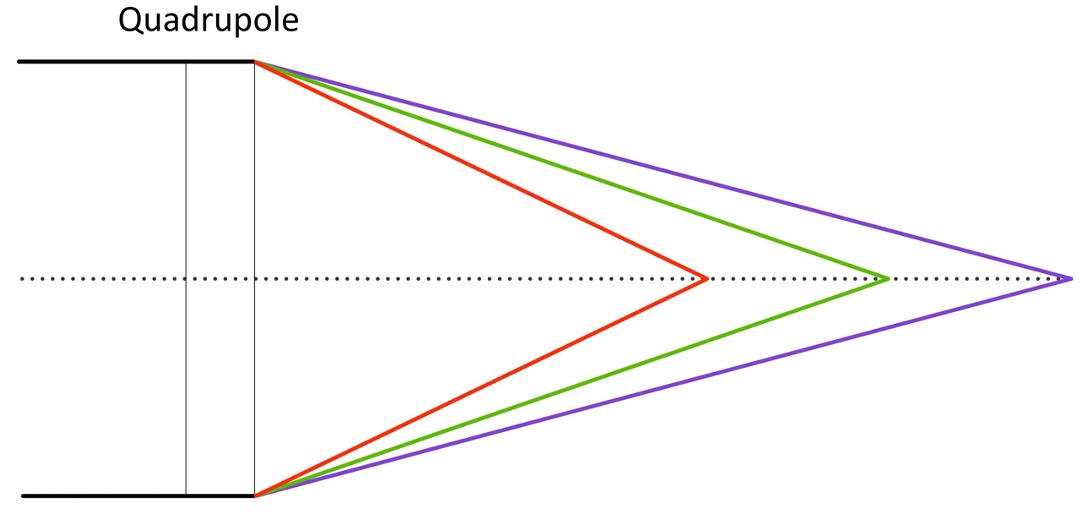
</div>


1. Convert the sequence of Tutorial 1: Part 3 in thin lenses with the following commands:
    
        select, flag=MAKETHIN, SLICE=5;
        MAKETHIN, SEQUENCE=MY_SEQUENCE;
        use, sequence=MY_SEQUENCE;
        
    It is important when defining the SEQUENCE to refer to the the center, to make it compatible with the makethin command!

    Note that this step is required to allow particle tracking in MAD-X.


2. With a matching block adjust the tunes of the cell to 0.25.


3. Using the chromaticities obtained from the TWISS, compute the tunes for particles with $\Delta p / p = 10^{-3}$.


4. Track a particle with initial coordinates x,y,px,py = (1,1,0,0) mm in 100 cells. Plot the x-px phase space. 
    
        track, dump;    
        start, x=1e-3, px=0, y=1e-3, py=0;    
        run, turns=100;   
        endtrack;

      **HINT**: In oder to access the track data using python you can print the output in a dataframe using the command: **particle1=myMad.table['track.obs0001.p0001'].dframe()**. If you have tracked two particles, the second particle output can be obtained via **particle2=myMad.table['track.obs0002.p0002'].dframe()**.
      

5. How does the particle move in the phase space, turn after turn? Do you see the tunes?


6. Track a particle with initial coordinates x,y,px,py=(100, 100, 0, 0) mm in 100 turns. Plot the x-px phase-space. Does something change with respect to the previous case? Why?


7. Repeat the tracking adding DELTAP=1e-2 to the track command. How does the phase space look now? is the tune still same? It may help to look only at the first 4 turns to get a clearer picture.

        track, dump, DELTAP=1e-2;  


In [1]:
from matplotlib import pyplot as plt
%matplotlib notebook
import numpy as np
from cpymad.madx import Madx 

In [2]:
myMad = Madx(stdout=True)

1. Convert the sequence of Tutorial 1: Part 3 in thin lenses with the following commands:
    
        MAKETHIN, SEQUENCE=MY_SEQUENCE;
        use, sequence=MY_SEQUENCE;

    Note that this step is required to allow particle tracking in MAD-X.

In [3]:
myMad = Madx(stdout=True)
myString='''
! *********************************************************************
! Definition of parameters
! *********************************************************************
!! General parameters
Lcell = 100;
nBend=736;

!! Dipole Parameters
Ld = 15;
Ad = 2*pi/nBend;

!! Quadrupole Parameters
K1F = 5e-3;
K1D = -K1F;
Lq =5;

! *********************************************************************
! Definition of magnets
! ********************************************************************* 

QF: QUADRUPOLE, L=Lq, K1:=K1F;
QD: QUADRUPOLE, L=Lq, K1:=K1D;
BM: SBEND, L=Ld, angle:=Ad;

! *********************************************************************
! Definition of sequence
! *********************************************************************

JUAS: SEQUENCE, REFER=center, L=100; !it is important to refer to the the center this time, to make it compatible with the makethin 
qf: QF, at=0+QF->L/2;
b1:  BM, at=10+BM->L/2;
b2:  BM, at=30+BM->L/2;
qd: QD, at=50+QD->L/2;
b3:  BM, at=60+BM->L/2;
b4:  BM, at=80+BM->L/2;
ENDSEQUENCE;

! *********************************************************************
! Definition of beam
! *********************************************************************

beam, particle=proton, energy=7000;

! *********************************************************************
! ACTIVATE SEQUENCE
! *********************************************************************

use, sequence=JUAS;

! *********************************************************************
! TWISS
! *********************************************************************

twiss, table= thick_sequence;

! *********************************************************************
! MEKETHIN
! *********************************************************************

select, flag=MAKETHIN, SLICE=1;
MAKETHIN, SEQUENCE=JUAS;

! *********************************************************************
! ACTIVATE NEW SEQUENCE
! *********************************************************************

use, sequence=JUAS;

! *********************************************************************
! TWISS
! *********************************************************************

twiss, table= thin_sequence;
'''
myMad.input(myString);

# Comparing the thick and thin sequence.

In [10]:
thinDF=myMad.table['thin_sequence'].dframe()
thinDF[["name", "keyword", "betx","bety","alfx", "alfy", "mux", "muy"]].head()

,name,keyword,betx,bety,alfx,alfy,mux,muy
#s,juas$start:1,marker,156.250598,41.032839,-2.000633,0.560449,0.000000,0.000000
drift_0[0],drift_0:0,drift,166.453864,38.430757,-2.080673,0.480384,0.002467,0.010026
qf,qf:1,multipole,166.453864,38.430757,2.080673,-0.480384,0.002467,0.010026
drift_1[0],drift_1:0,drift,137.044669,47.437966,1.840553,-0.720577,0.010374,0.038128
b1_den,b1_den:1,dipedge,137.044669,47.437966,1.840553,-0.720577,0.010374,0.038128


In [258]:
thickDF=myMad.table['thick_sequence'].dframe()
thickDF[["name", "keyword", "betx","bety","alfx", "alfy", "mux", "muy"]].head()

,name,keyword,betx,bety,alfx,alfy,mux,muy
#s,juas$start:1,marker,159.768958,43.038476,-2.002851,0.591962,0.000000,0.000000
qf,qf:1,quadrupole,159.768958,43.038476,2.002851,-0.591962,0.004878,0.018922
drift_0[0],drift_0:0,drift,140.524610,49.742516,1.846018,-0.748847,0.010190,0.036154
b1,b1:1,sbend,92.193833,79.267739,1.375955,-1.219502,0.031225,0.074545
drift_1[0],drift_1:0,drift,79.218837,92.247180,1.219044,-1.376387,0.040542,0.083856


<IPython.core.display.Javascript object>


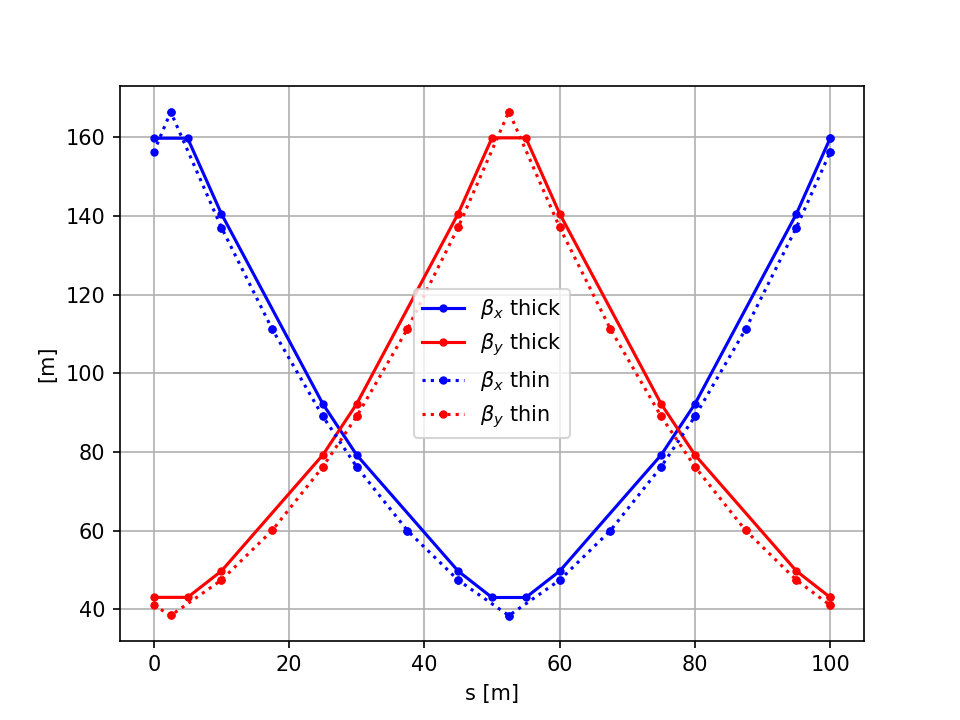

In [11]:
thickDF=myMad.table['thick_sequence'].dframe()
thinDF=myMad.table['thin_sequence'].dframe()

plt.plot(thickDF['s'],thickDF['betx'],'.-b',label='$\\beta_x$ thick')
plt.plot(thickDF['s'],thickDF['bety'],'.-r',label='$\\beta_y$ thick')

plt.plot(thinDF['s'],thinDF['betx'],'.:b',label='$\\beta_x$ thin')
plt.plot(thinDF['s'],thinDF['bety'],'.:r',label='$\\beta_y$ thin')

plt.xlabel('s [m]')
plt.ylabel('[m]')
plt.grid()
plt.legend()

# Matching the tunes

2. With a matching block adjust the tunes of the cell to 0.25.

In [13]:
myString='''

//*************************************************//
!   ACTIVATE THE SEQUENCE
//*************************************************//

use, sequence=JUAS;

//*************************************************//
!   MATCHING OF THE TUNES
//*************************************************//

match, sequence=JUAS;
!! Variables
vary,name=K1F,step=0.0001;
vary,name=K1D,step=0.0001;
!! Constraints
global, Q1=0.25;
global, Q2=0.25;
!! The next line ask MAD-X to do the matching itself
LMDIF, calls = 1000, tolerance=1E-12;
endmatch;

//*************************************************//
!   TWISS
//*************************************************//

twiss, table=thin_new;

value, beam->beta;
'''
myMad.input(myString);

# Chromaticity
3. Using the chromaticities obtained from the TWISS, compute the tunes for $\Delta p / p = 10^{-3}$.

$\Delta Q = dq* \frac{\Delta p}{p}$


**REMEMBER** That the derivative functions in MAD-X are normalized by the relativistic factor beta.

We could assume ultra-relativistic beam.

In [10]:
beta_rel=myMad.sequence['JUAS'].beam.beta
print (beta_rel)

0.9999999910167906


In [11]:
dq1_ref=myMad.table['summ'].dq1[0]
print(dq1_ref)

-0.3181838690045014


In [9]:
# Variation on the tune
dq1_ref*beta_rel*1e-3

-0.0003181838661461891

This detuning is quite important.

In [12]:
#Tune of the machine
tune_onmomentum=myMad.table['summ'].q1[0]
print(tune_onmomentum)
tune_offmomentum=myMad.table['summ'].q1[0]-0.00031
print(tune_offmomentum)

0.25000000003997125
0.24969000003997124


# Tracking
4. Track a particle with initial coordinates x,y,px,py = (1,1,0,0) mm for 100 turns. Plot the x-px phase space. 
    
        track, dump;    
        start, x=1e-3, px=0, y=1e-3, py=0;    
        run, turns=100;   
        endtrack;
        
5. How does the particle move in the phase space, turn after turn? Do you see the tunes?
    

In [38]:
myString='''
//*************************************************//
!   TRACKING
//*************************************************//

track,dump,file='linear_machine', DELTAP=0.00;
start, x= 1e-3, px=0, y= 1e-3, py=0;
run,turns=100;
endtrack;

!plot, file="linear_machine",table=track,haxis=x,vaxis=px,
!particle=1,2, colour=100;
!plot, file="linear_machine",table=track,haxis=y,vaxis=py,
!particle=1,2, colour=100;
'''
myMad.input(myString);

In [39]:
#When activating the option dump on the trck module  new table is generated by MADX with the tracking results
particle1=myMad.table['track.obs0001.p0001'].dframe()

In [40]:
particle1.head()

,number,turn,x,px,y,py,t,pt,s,e
#e,1.0,0.0,0.001000,0.000000e+00,0.001000,0.000000e+00,0.000000e+00,0.0,0.0,7000.0
#e,1.0,1.0,-0.002313,-3.996887e-05,0.000514,-3.999232e-05,1.901139e-05,0.0,0.0,7000.0
#e,1.0,2.0,-0.001000,2.117014e-13,-0.001000,2.118460e-13,6.517432e-05,0.0,0.0,7000.0
#e,1.0,3.0,0.002313,3.996887e-05,-0.000514,3.999232e-05,4.593109e-05,0.0,0.0,7000.0
#e,1.0,4.0,0.001000,-4.234028e-13,0.001000,-4.236920e-13,-3.197509e-07,0.0,0.0,7000.0


<IPython.core.display.Javascript object>


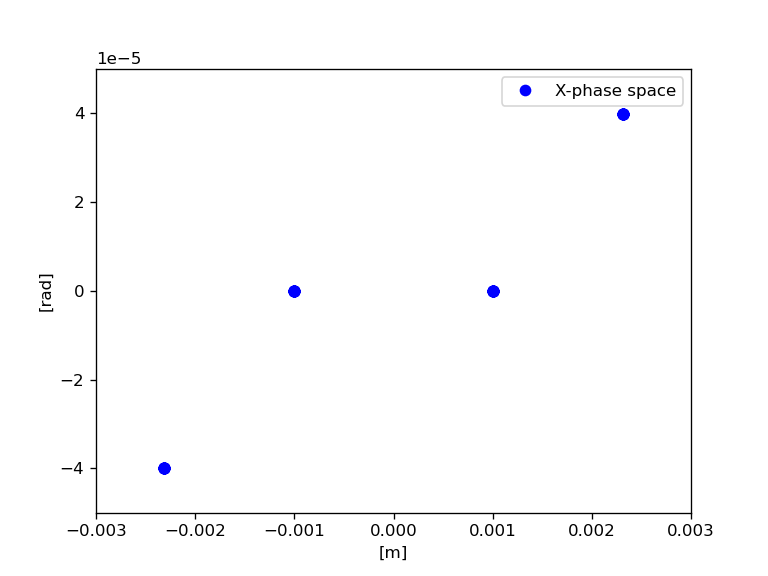

(-5e-05, 5e-05)

In [41]:
%matplotlib notebook
plt.plot(particle1['x'],particle1['px'],'ob',label='X-phase space')
#plt.plot(particle2['x'],particle2['px'],'or',label='X-phase space')
plt.xlabel('[m]')
plt.ylabel('[rad]')
plt.legend(loc='best')
plt.xlim(-0.003,0.003)
plt.ylim(-5e-5, 5e-5)

<IPython.core.display.Javascript object>


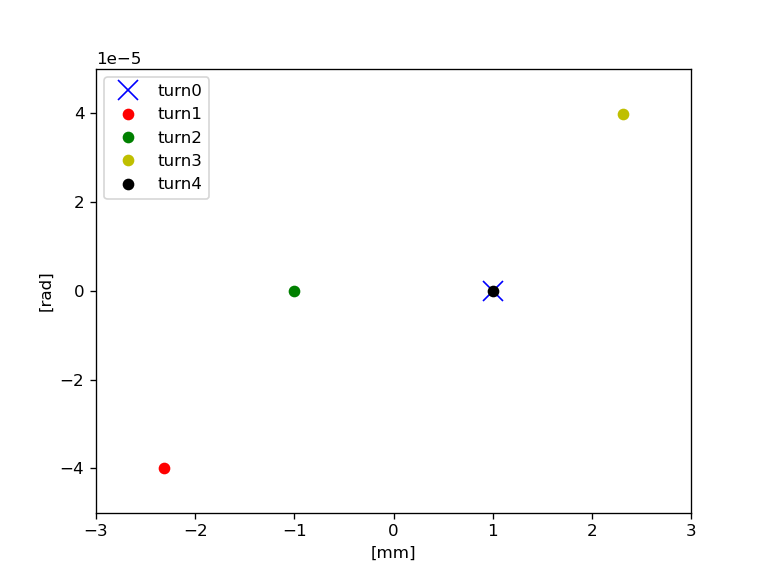

(-5e-05, 5e-05)

In [45]:
%matplotlib notebook
turn0=particle1[particle1["turn"]==0]
turn1=particle1[particle1["turn"]==1]
turn2=particle1[particle1["turn"]==2]
turn3=particle1[particle1["turn"]==3]
turn4=particle1[particle1["turn"]==4]
plt.plot(turn0['x']*1e3,turn0['px'],'xb',markersize=12,label='turn0')
plt.plot(turn1['x']*1e3,turn1['px'],'or',label='turn1')
plt.plot(turn2['x']*1e3,turn2['px'],'og',label='turn2')
plt.plot(turn3['x']*1e3,turn3['px'],'oy',label='turn3')
plt.plot(turn4['x']*1e3,turn4['px'],'ok',label='turn4')
plt.xlabel('[mm]')
plt.ylabel('[rad]')
plt.legend(loc='best')
plt.xlim(-3,3)
plt.ylim(-5e-5, 5e-5)

<IPython.core.display.Javascript object>


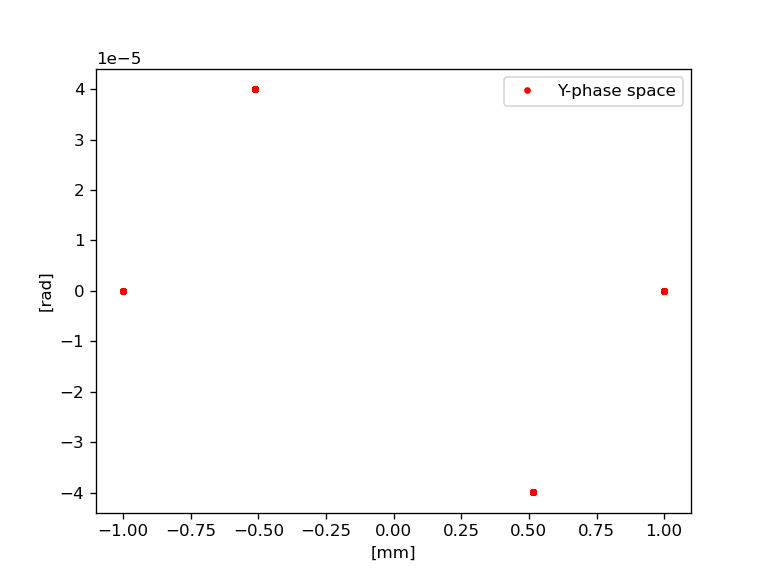

In [46]:
# Plot visualization options
%matplotlib notebook
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.dpi'] = 80

plt.plot(particle1['y']*1e3,particle1['py'],'.r',label='Y-phase space')
plt.xlabel('[mm]')
plt.ylabel('[rad]')
plt.legend(loc='best')

<IPython.core.display.Javascript object>


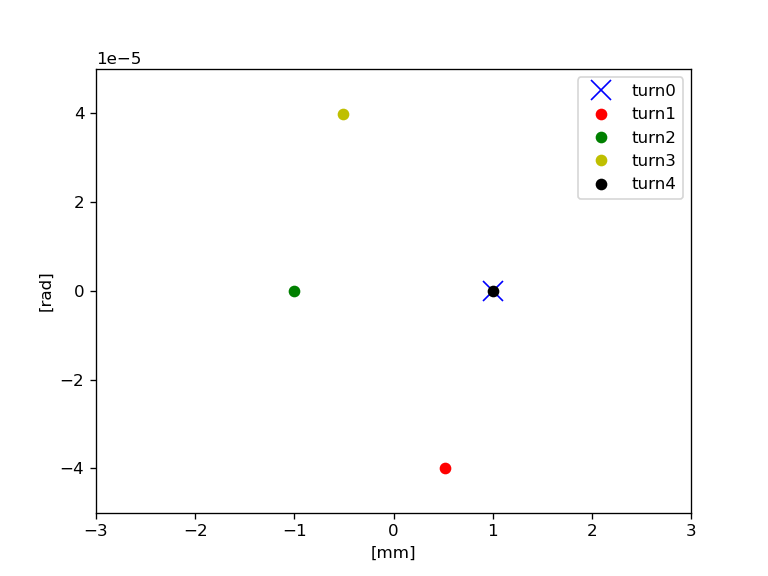

(-5e-05, 5e-05)

In [49]:
%matplotlib notebook
# Plot visualization options
%matplotlib notebook
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.dpi'] = 80

turn0=particle1[particle1["turn"]==0]
turn1=particle1[particle1["turn"]==1]
turn2=particle1[particle1["turn"]==2]
turn3=particle1[particle1["turn"]==3]
turn4=particle1[particle1["turn"]==4]
plt.plot(turn0['y']*1e3,turn0['py'],'xb',markersize=12,label='turn0')
plt.plot(turn1['y']*1e3,turn1['py'],'or',label='turn1')
plt.plot(turn2['y']*1e3,turn2['py'],'og',label='turn2')
plt.plot(turn3['y']*1e3,turn3['py'],'oy',label='turn3')
plt.plot(turn4['y']*1e3,turn4['py'],'ok',label='turn4')
plt.xlabel('[mm]')
plt.ylabel('[rad]')
plt.legend(loc='best')
plt.xlim(-3,3)
plt.ylim(-5e-5, 5e-5)

# Traking particles with larger amplitude
6. Track a particle with initial coordinates x,y,px,py=(100, 100, 0, 0) mm in 100 cells. Plot the x-px phase-space. Does something change with respect to the previous case? Why?

In [50]:
myString='''
//*************************************************//
!   TRACKING
//*************************************************//

track,dump,file='linear_machine', DELTAP=0.00;
start, x= 1e-1, px=0, y= 1e-1, py=0;
run,turns=100;
endtrack;

!plot, file="linear_machine",table=track,haxis=x,vaxis=px,
!particle=1,2, colour=100;
!plot, file="linear_machine",table=track,haxis=y,vaxis=py,
!particle=1,2, colour=100;
'''
myMad.input(myString);

In [51]:
particle2=myMad.table['track.obs0001.p0001'].dframe()

<IPython.core.display.Javascript object>


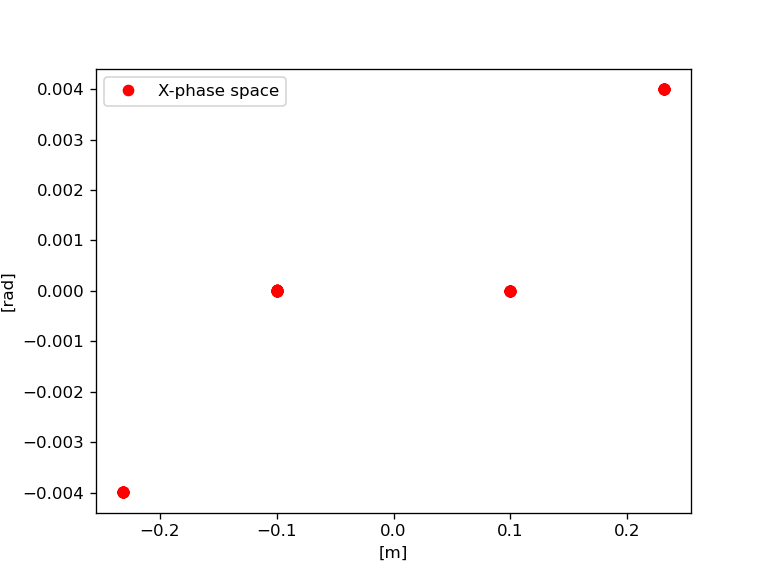

In [52]:
# Plot visualization options
%matplotlib notebook
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.dpi'] = 80

#plt.plot(particle1['x'],particle1['px'],'ob',label='X-phase space')
plt.plot(particle2['x'],particle2['px'],'or',label='X-phase space')
plt.xlabel('[m]')
plt.ylabel('[rad]')
plt.legend(loc='best')
#plt.xlim(-0.003,0.003)
#plt.ylim(-5e-5, 5e-5)

<IPython.core.display.Javascript object>


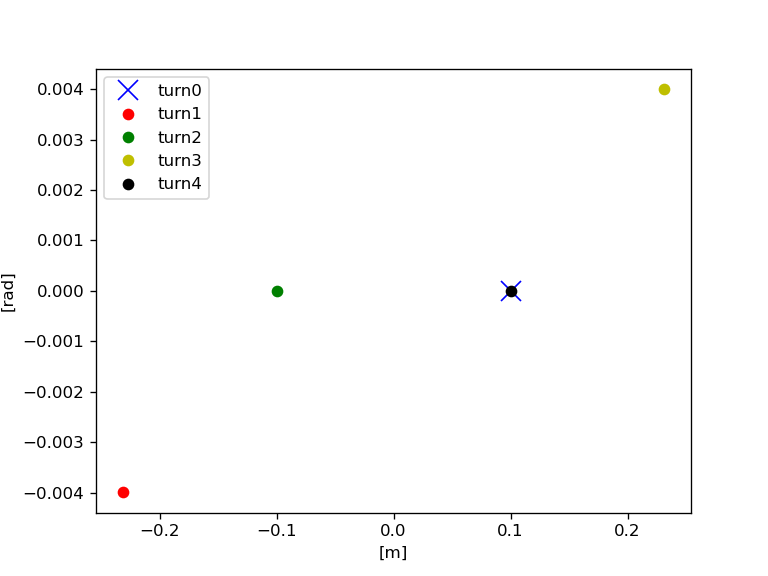

In [53]:
# Plot visualization options
%matplotlib notebook
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.dpi'] = 80

turn0=particle2[particle2["turn"]==0]
turn1=particle2[particle2["turn"]==1]
turn2=particle2[particle2["turn"]==2]
turn3=particle2[particle2["turn"]==3]
turn4=particle2[particle2["turn"]==4]
plt.plot(turn0['x'],turn0['px'],'xb',markersize=12,label='turn0')
plt.plot(turn1['x'],turn1['px'],'or',label='turn1')
plt.plot(turn2['x'],turn2['px'],'og',label='turn2')
plt.plot(turn3['x'],turn3['px'],'oy',label='turn3')
plt.plot(turn4['x'],turn4['px'],'ok',label='turn4')
plt.xlabel('[m]')
plt.ylabel('[rad]')
plt.legend(loc='best')

<IPython.core.display.Javascript object>


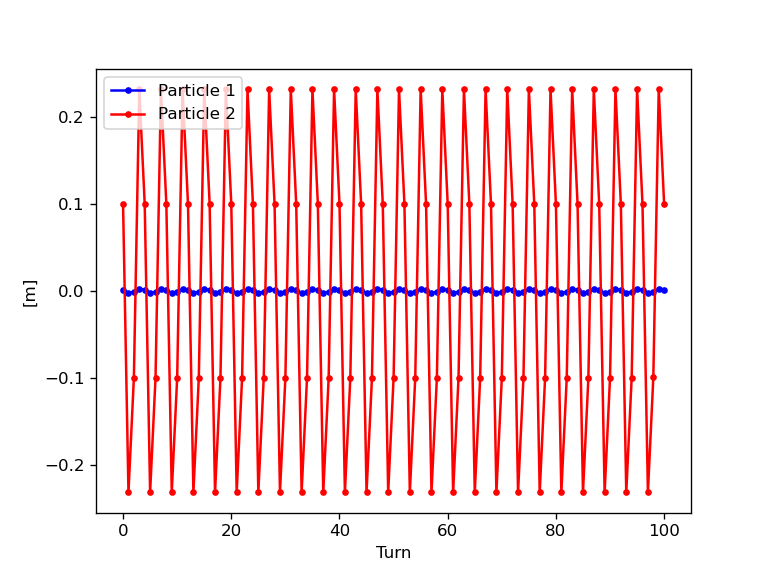

In [57]:
# We can also plot the amplitude of the particle vs the turn number
# Plot visualization options
%matplotlib notebook
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.dpi'] = 80

plt.plot(particle1['turn'],particle1['x'],'.-b', label='Particle 1')
plt.plot(particle2['turn'],particle2['x'],'.-r', label='Particle 2')
plt.xlabel('Turn')
plt.ylabel('[m]');
plt.legend(loc='best');

<IPython.core.display.Javascript object>


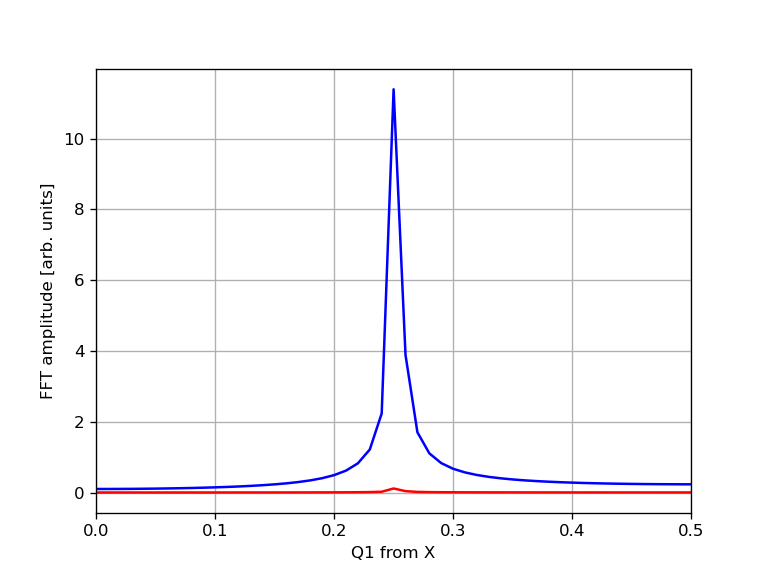

In [73]:
%matplotlib notebook
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.dpi'] = 80

# The amplitude of the FFT of the particle amplitude oscilations gives as a mesure of the tune
# Just play with an FFT on 
plt.figure()
plt.plot(np.linspace(0,1,len(particle1['x'])), np.abs(np.fft.fft(particle1['x'])), 'r')
plt.plot(np.linspace(0,1,len(particle2['x'])), np.abs(np.fft.fft(particle2['x'])), 'b')
plt.xlabel('Q1 from X')
plt.ylabel('FFT amplitude [arb. units]');
plt.xlim(0,0.5)# The max. possible frequency for a given sampling rate that can be reconstruct is given by the Nyquist limit= sampling frecuency/2. In our case the sampling rate is 1, so the limit is 0.5.
plt.grid()

Answer: We obtain a similar plot as before but with larger amplitues.

# Track off-momentum

7. Repeat point 4 adding DELTAP=1e-2 to the track command. How does the phase space look now? Is the tune still same? It may help to look only at the first 4 turns to get a clearer picture.

In [74]:
myString='''
//*************************************************//
!   TRACKING
//*************************************************//

track,dump,file='linear_machine_off_energy', DELTAP=0.01;
start, x= 1e-3, px=0, y= 1e-3, py=0;
start, x= 1e-1, px=0, y= 1e-1, py=0;
run,turns=100;
endtrack;

!plot, file="linear_machine",table=track,haxis=x,vaxis=px,
!particle=1,2, colour=100;
!plot, file="linear_machine",table=track,haxis=y,vaxis=py,
!particle=1,2, colour=100;
'''
myMad.input(myString);

In [75]:
off_momentum_particle1=myMad.table['track.obs0001.p0001'].dframe()
off_momentum_particle2=myMad.table['track.obs0001.p0002'].dframe()

<IPython.core.display.Javascript object>


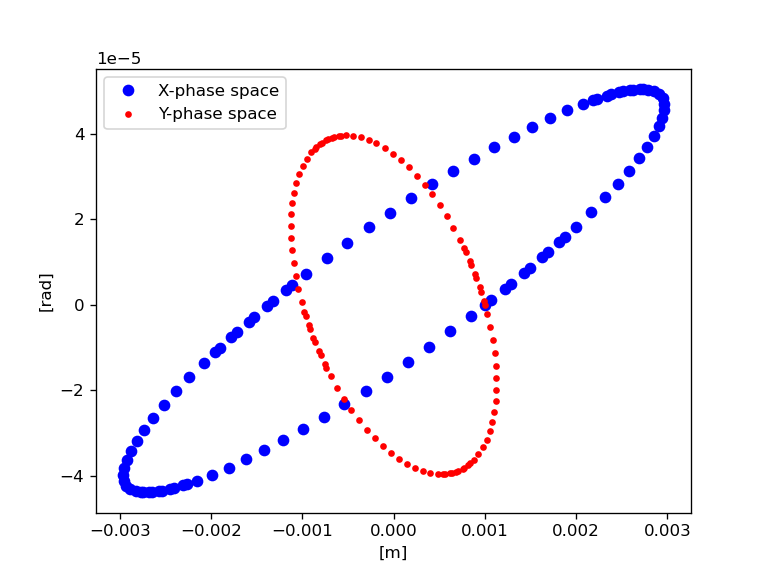

In [76]:
%matplotlib notebook
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.dpi'] = 80

plt.plot(off_momentum_particle1['x'],off_momentum_particle1['px'],'ob',label='X-phase space')
plt.plot(off_momentum_particle1['y'],off_momentum_particle1['py'],'.r',label='Y-phase space')
plt.xlabel('[m]')
plt.ylabel('[rad]')
plt.legend(loc='best')

As we track off-momentum particles the tune is afected by the natural chromaticity of the FODO and it is not 0.25 anymore.

<IPython.core.display.Javascript object>


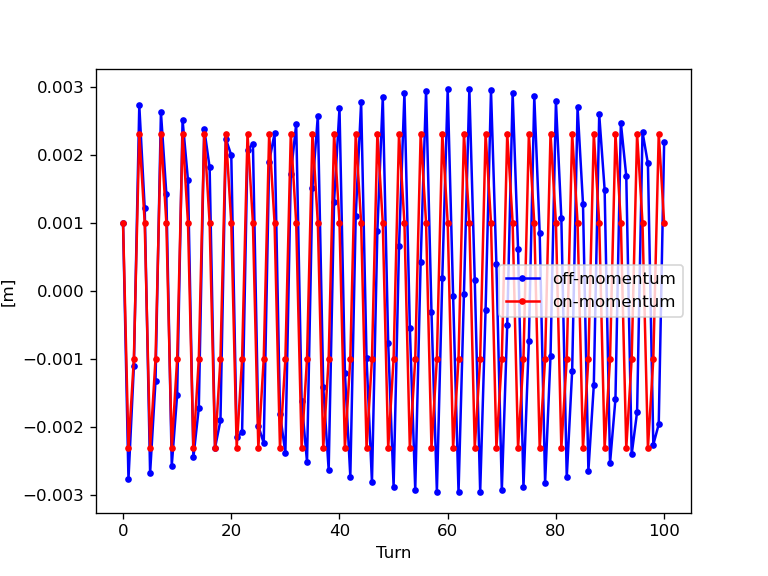

In [77]:
%matplotlib notebook
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.dpi'] = 80

plt.plot(off_momentum_particle1['turn'],off_momentum_particle1['x'],'.-b', label='off-momentum')
plt.plot(particle1['turn'],particle1['x'],'.-r', label='on-momentum')
plt.xlabel('Turn')
plt.ylabel('[m]');
plt.legend(loc='best');

<IPython.core.display.Javascript object>


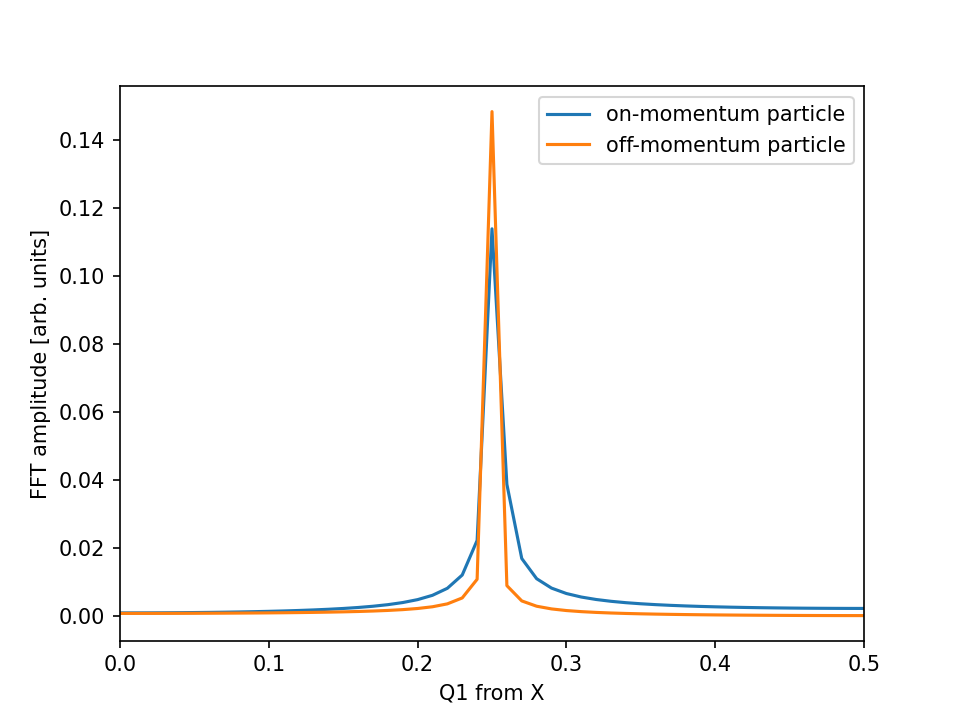

In [44]:
%matplotlib notebook
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.dpi'] = 80

plt.plot(np.linspace(0,1,len(particle1['x'])), np.abs(np.fft.fft(particle1['x'])),label="on-momentum particle")
plt.plot(np.linspace(0,1,len(off_momentum_particle1['x'])), np.abs(np.fft.fft(off_momentum_particle1['x'])),label="off-momentum particle")
plt.xlim(0,.5)
plt.xlabel('Q1 from X')
plt.ylabel('FFT amplitude [arb. units]');
plt.legend()

In real machines, with more and stronget quadrupoles the impact could be higher and correction schemes are required. This is what we are going to see in the next tutorial.